In [1]:
import math

import torch
import torchmetrics.classification
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix

from dataset import get_dataset
from main import ResNetModel
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import variance

wandb: Currently logged in as: jacob314. Use `wandb login --relogin` to force relogin


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = ResNetModel.load_from_checkpoint('resnet18-sp-2.cpkt', map_location=device)

trainer = pl.Trainer(
    # We run on a single GPU (if possible)
    accelerator="auto",
    devices=1,
    # How many epochs to train for if no patience is set
    max_epochs=10,
    logger=False,
)

val_set_with_metadata = get_dataset("test", include_metadata=True)

val_loader = DataLoader(val_set_with_metadata, batch_size=1, shuffle=False, drop_last=False, num_workers=1)

all_labels = []
for batch in val_loader:
    imgs, labels = batch
    all_labels.append(labels)

print(all_labels)
predictions = trainer.predict(model, val_loader)
predictions = torch.cat(predictions)
print(predictions)


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[[tensor([1]), tensor([40.], dtype=torch.float64), ('female',)], [tensor([1]), tensor([70.], dtype=torch.float64), ('male',)], [tensor([3]), tensor([70.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([35.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([75.], dtype=torch.float64), ('female',)], [tensor([0]), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64)], [tensor([1]), tensor([45.], dtype=torch.float64), ('male',)], [tensor([3]), tensor([70.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([40.], dtype=torch.float64), ('female',)], [tensor([1]), tensor([55.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([45.], dtype=torch.float64), ('male',)], [tensor([3]), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64)], [tensor([1]), tensor([45.], dtype=torch.float64), ('female',)], [tensor([3]), tensor([75.], dtype=torch.float64), ('male',)], [tensor([1]), tensor([nan], dtype=torch.float64), tensor([nan], dtype=tor

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

tensor([1, 2, 3,  ..., 3, 0, 3])


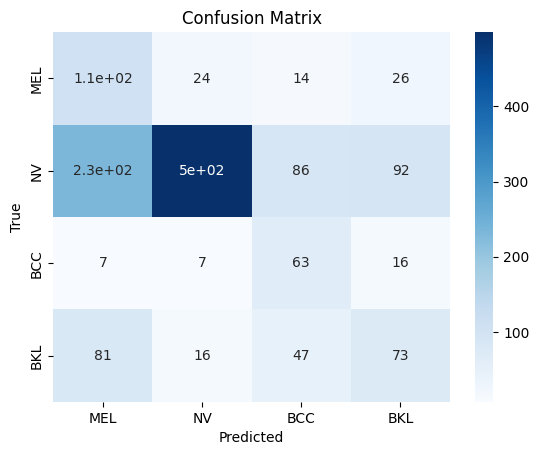

In [3]:
confm = ConfusionMatrix(task="multiclass", num_classes=4)

confm_labels = []
for label in all_labels:
    confm_labels.append(label[0])

confm_labels = torch.cat(confm_labels)

result = confm(predictions, confm_labels)

labels = ["MEL", "NV", "BCC", "BKL"]
sns.heatmap(result, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("conf_ma.png")

# wandb.log({"confma": wandb.Image("conf_ma.png")})


In [4]:
# calculate accuracy based on sex

male_predictions = []
male_labels = []
female_predictions = []
female_labels = []

for i in range(len(predictions)):
    if all_labels[i][2][0] == 'male':
        male_predictions.append(torch.unsqueeze(predictions[i], dim=0))
        male_labels.append(all_labels[i][0])
    elif all_labels[i][2][0] == 'female':
        female_predictions.append(torch.unsqueeze(predictions[i], dim=0))
        female_labels.append(all_labels[i][0])
    else:
        print(f"unknown: {all_labels[i][2]}")

print(male_labels)
print(male_predictions)

metric = torchmetrics.classification.MulticlassAccuracy(num_classes=4, average='weighted')

male_accuracy = metric(torch.cat(male_predictions), torch.cat(male_labels))
female_accuracy = metric(torch.cat(female_predictions), torch.cat(female_labels))

overall_accuracy = metric(predictions, confm_labels)

#wandb.log({"overall_accuracy": overall_accuracy})
#wandb.log({"male_accuracy": male_accuracy})
print(f"male_acc: {male_accuracy}")
#wandb.log({"female_accuracy": female_accuracy})
print(f"female_acc: {female_accuracy}")

print(f"bias: {variance([male_accuracy.item(), female_accuracy.item()])}")


unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=torch.float64)
unknown: tensor([nan], dtype=tor

In [5]:
age_groups = ["85.0", "80.0", "75.0", "65.0", "60.0", "55.0", "50.0", "45.0", "40.0", "35.0", "30.0", "25.0", "20.0", "15.0", "10.0", "5.0", "0.0", "-10.0"]
            

age_based_predictions = {"85.0": [], "80.0": [], "75.0": [], "70.0": [], "65.0": [], "60.0": [], "55.0": [], "50.0": [], "45.0": [], "40.0": [], "35.0": [], "30.0": [], "25.0": [], "20.0": [], "15.0": [], "10.0": [], "5.0": [], "0.0": [], "-10.0": []}
age_labels = {"85.0": [], "80.0": [], "75.0": [], "70.0": [], "65.0": [], "60.0": [], "55.0": [], "50.0": [], "45.0": [], "40.0": [], "35.0": [], "30.0": [], "25.0": [], "20.0": [], "15.0": [], "10.0": [], "5.0": [], "0.0": [], "-10.0": []}

for i in range(len(predictions)):
    age = str(all_labels[i][1][0].item())
    if age == 'nan':
        continue

    age_based_predictions[age].append(torch.unsqueeze(predictions[i], dim=0))
    age_labels[age].append(all_labels[i][0])
    

metric = torchmetrics.classification.MulticlassAccuracy(num_classes=4, average='weighted')

accuracies = {}
acc_list = []
for age in age_groups:
    print(f"{age} has {len(age_based_predictions[age])} samples")
    if age == "-10.0":
        continue
    if len(age_based_predictions[age]) > 0:
        accuracies[age] = metric(torch.cat(age_based_predictions[age]), torch.cat(age_labels[age])).item()
        acc_list.append(accuracies[age])

overall_accuracy = metric(predictions, confm_labels)

print(accuracies)
print(f"overall_accuracy: {overall_accuracy}")



print(f"bias: {variance(acc_list)}")



85.0 has 19 samples
80.0 has 44 samples
75.0 has 61 samples
65.0 has 108 samples
60.0 has 81 samples
55.0 has 121 samples
50.0 has 136 samples
45.0 has 163 samples
40.0 has 106 samples
35.0 has 80 samples
30.0 has 45 samples
25.0 has 45 samples
20.0 has 26 samples
15.0 has 9 samples
10.0 has 10 samples
5.0 has 18 samples
0.0 has 0 samples
-10.0 has 0 samples
{'85.0': 0.5789473652839661, '80.0': 0.5681818127632141, '75.0': 0.49180325865745544, '65.0': 0.5, '60.0': 0.6172839403152466, '55.0': 0.7272726893424988, '50.0': 0.6617647409439087, '45.0': 0.7423312664031982, '40.0': 0.6792453527450562, '35.0': 0.574999988079071, '30.0': 0.46666666865348816, '25.0': 0.2888889014720917, '20.0': 0.19230769574642181, '15.0': 0.3333333432674408, '10.0': 0.20000000298023224, '5.0': 0.3333333432674408}
overall_accuracy: 0.533812940120697
bias: 0.032319552097600346


In [6]:
age_groups = ["upto30", "35to55", "60up", "-10.0"]
            

age_based_predictions = {"upto30": [], "35to55": [], "60up": [], "-10.0": []}
age_labels = {"upto30": [], "35to55": [], "60up": [], "-10.0": []}

for i in range(len(predictions)):
    age = all_labels[i][1][0].item()
    if age <= 0.0:
        age = "-10.0"
    if age <= 30.0:
        age = "upto30"
    elif age <= 55.0:
        age = "35to55"
    else:
        age = "60up"
    
    age_based_predictions[age].append(torch.unsqueeze(predictions[i], dim=0))
    age_labels[age].append(all_labels[i][0])
    

metric = torchmetrics.classification.MulticlassAccuracy(num_classes=4, average='weighted')

accuracies = {}
acc_list = []
for age in age_groups:
    print(f"{age} has {len(age_based_predictions[age])} samples")
    if age == "-10.0":
        continue
    if len(age_based_predictions[age]) > 0:
        accuracies[age] = metric(torch.cat(age_based_predictions[age]), torch.cat(age_labels[age])).item()
        acc_list.append(accuracies[age])

overall_accuracy = metric(predictions, confm_labels)

print(accuracies)
print(f"overall_accuracy: {overall_accuracy}")



print(f"bias: {variance(acc_list)}")


upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
-10.0 has 0 samples
{'upto30': 0.32679739594459534, '35to55': 0.6881188154220581, '60up': 0.4358161687850952}
overall_accuracy: 0.533812940120697
bias: 0.034349147750812214



## Resnet without new sample probs

upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
-10.0 has 0 samples
{'upto30': 0.24836601316928864, '35to55': 0.6716171503067017, '60up': 0.48335975408554077}
overall_accuracy: 0.539568305015564
bias: 0.0449674050983165

## Resnet with new sample probs

upto30 has 153 samples
35to55 has 606 samples
60up has 631 samples
-10.0 has 0 samples
{'upto30': 0.32679739594459534, '35to55': 0.6881188154220581, '60up': 0.4358161687850952}
overall_accuracy: 0.533812940120697
bias: 0.034349147750812214
